In [1]:
## new classification model
import os
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import optimizers
import tensorflow.keras.models as models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import vgg16, vgg19, resnet, inception_v3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

np.random.seed(123)
%matplotlib inline

In [2]:
def fetch_preprocess_data(data_dir = '/Users/jacksimonson/Springboard_Work/data/',
                          img_dim = (250, 250)):
    start = time()
    print('Fetching data...')

    files = glob.glob('{}training-image/*'.format(data_dir))
    benign_train = np.array([fn for fn in files if 'benign' in fn.lower()])
    malignant_train = np.array([fn for fn in files if 'malignant' in fn.lower()])
    print(f'benign training images: {len(benign_train)}\nmalignant training images: {len(malignant_train)}')
    
    files = glob.glob('{}test-image/*'.format(data_dir))
    benign_test = np.array([fn for fn in files if 'benign' in fn.lower()])
    malignant_test = np.array([fn for fn in files if 'malignant' in fn.lower()])
    print(f'benign test images: {len(benign_test)}\nmalignant test images: {len(malignant_test)}')
    
    print('\nBenign datasets:', benign_train.shape, benign_test.shape)
    print('Malignant datasets:', malignant_train.shape, malignant_test.shape)
    
    print('\nMoving data into sub-directories if necessary...')
    train_dir = '{}training_image_data'.format(data_dir)
    test_dir = '{}test_image_data'.format(data_dir)

    train_files = np.concatenate([benign_train, malignant_train])
    test_files = np.concatenate([benign_test, malignant_test])

    if os.path.isdir(train_dir):
        if len(os.listdir(train_dir)):
            print('    Training data already in correct directory')
        else:
            for fn in train_files:
                shutil.copy(fn, train_dir)
            print('    Training data moved')
    else:
        os.mkdir(train_dir)
        for fn in train_files:
                shutil.copy(fn, train_dir)
        print('    Training data moved')

    if os.path.isdir(test_dir):
        if len(os.listdir(test_dir)):
            print('    Test data already in correct directory')
        else:
            for fn in test_files:
                shutil.copy(fn, test_dir)
            print('    Test data moved')
    else:
        os.mkdir(test_dir)
        for fn in test_files:
                shutil.copy(fn, test_dir)
        print('    Test data moved')
    
    # train
    print('\nTransfering training images to arrays of dimension {}...'.format(img_dim))
    train_files = glob.glob('{}/*'.format(train_dir))
    train_imgs = [img_to_array(load_img(img, target_size=img_dim)) for img in train_files]
    train_imgs = np.array(train_imgs)
    train_labels = [fn.split('/')[-1].split('_')[-1].replace('.png','').lower().strip() for fn in train_files]

    print('Train dataset shape:', train_imgs.shape)
    
    train_imgs_scaled = train_imgs.astype('float32')
    train_imgs_scaled /= 255

    
    input_shape = (img_dim[0], img_dim[1], 3)
    le = LabelEncoder()
    le.fit(train_labels)
    train_labels_enc = le.transform(train_labels)

    # test
    print('\nTransfering test images to arrays of dimension {}...'.format(img_dim))
    test_files = glob.glob('{}/*'.format(test_dir))
    test_imgs = [img_to_array(load_img(img, target_size=img_dim)) for img in test_files]
    test_imgs = np.array(test_imgs)
    test_labels = [fn.split('/')[-1].split('_')[-1].replace('.png','').lower().strip() for fn in test_files]

    print('Train dataset shape:', train_imgs.shape)
    
    test_imgs_scaled = test_imgs.astype('float32')
    test_imgs_scaled /= 255
    
    input_shape = (img_dim[0], img_dim[1], 3)
    test_labels_enc = le.transform(test_labels)
    
    end = time()
    elapsed = (end - start)/60
    print('\nData processing time is %f minutes.' % elapsed)
    
    return train_imgs, train_imgs_scaled, train_labels_enc, test_imgs, test_imgs_scaled, test_labels_enc, input_shape


In [3]:
# process data
train_imgs, train_imgs_scaled, train_labels_enc, test_imgs, test_imgs_scaled, test_labels_enc, input_shape = fetch_preprocess_data(data_dir = '/Users/jacksimonson/Springboard_Work/data/',
                                                                                     img_dim = (250, 250))

Fetching data...
benign training images: 1040
malignant training images: 1113
benign test images: 307
malignant test images: 264

Benign datasets: (1040,) (307,)
Malignant datasets: (1113,) (264,)

Moving data into sub-directories if necessary...
    Training data already in correct directory
    Test data already in correct directory

Transfering training images to arrays of dimension (250, 250)...
Train dataset shape: (2153, 250, 250, 3)

Transfering test images to arrays of dimension (250, 250)...
Train dataset shape: (2153, 250, 250, 3)

Data processing time is 7.749864 minutes.


Example train image


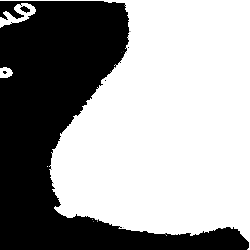

In [4]:
print(f'Example train image')
array_to_img(train_imgs[0])

### Vanilla CNN

In [5]:
def vanilla_cnn(batch_size = 30, num_classes = 2, epochs = 30, train_steps = 10, val_steps = 5,
                validation_split = 0.2, loss='binary_crossentropy', 
                metrics=['accuracy'], optimizer = optimizers.RMSprop(lr = 1e-4),
                train_batch_size = 30, val_batch_size = 20, augment = False,
                train_imgs_scaled = None, train_labels_enc = None, input_shape = None,
                train_imgs = None, model_path = '/Users/jacksimonson/Springboard_Work'):
    
    start = time()
    
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(loss = loss,
                  optimizer=optimizer,
                  metrics=metrics)

    print(model.summary())
    
    if augment:
        train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                           width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                           horizontal_flip=True, fill_mode='nearest', validation_split = validation_split)

        train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=train_batch_size)
        val_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=val_batch_size)
        
        history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=epochs,
                            validation_data=val_generator, validation_steps=val_steps, 
                            verbose=1)
    else:
        history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                            validation_split = validation_split,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1)        
        
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    if augment:
        t = f.suptitle('Basic CNN with Augmentation', fontsize=12)
    else:
        t = f.suptitle('Basic CNN', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs + 1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
    
    if augment:
        model_file_path = f'{model_path}/vanilla_cnn_model_with_augmentation.h5'
        model.save(model_file_path)
    else:
        model_file_path = f'{model_path}/vanilla_cnn_model.h5'
        model.save(model_file_path)
    
    end = time()
    elapsed = (end - start)/60
    if augment:
        print('Vanilla CNN with augmentation train time is %f minutes.' % elapsed)
    else:
        print('Vanilla CNN train time is %f minutes.' % elapsed)
    
    return model, history, f, (ax1, ax2), model_file_path

### Vanilla CNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       1

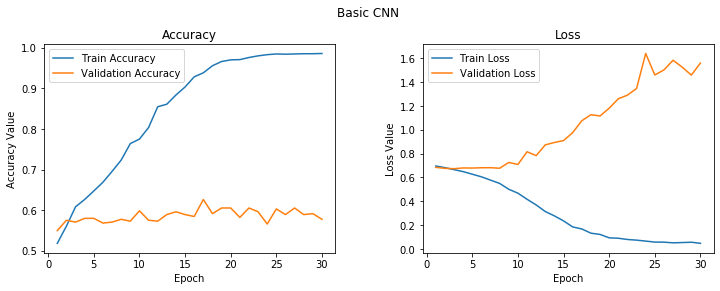

In [6]:
vanilla_model, vanilla_history, vanilla_f, (vanilla_ax1, vanilla_ax2), vanilla_model_file_path = vanilla_cnn(train_imgs_scaled = train_imgs_scaled,
                                                                                                             train_labels_enc = train_labels_enc,
                                                                                                             input_shape = input_shape,
                                                                                                             train_imgs = train_imgs)

### Vanilla CNN with Augmentation

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 248, 248, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 122, 122, 64)      9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 128)      

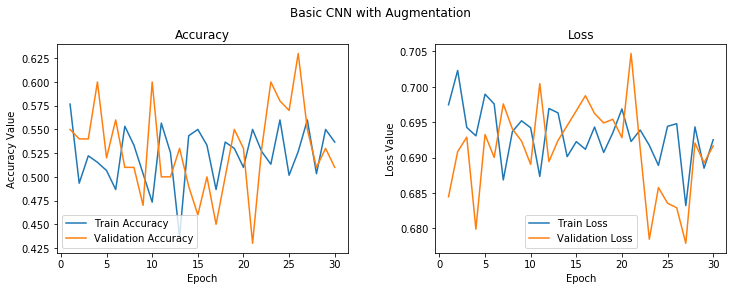

In [7]:
vanilla_model_augment, vanilla_history_augment, vanilla_f_augment, (vanilla_ax1_augment, vanilla_ax2_augment), vanilla_model_augment_file_path = vanilla_cnn(train_imgs_scaled = train_imgs_scaled,
                                                                                                                                                             train_labels_enc = train_labels_enc,
                                                                                                                                                             input_shape = input_shape,
                                                                                                                                                             train_imgs = train_imgs,
                                                                                                                                                             augment = True)

### Transfer Learning

In [13]:
# function to fit and train classifier
def run_transfer_classification(in_model = None, model_name = None, epochs = 25, train_steps = 10,
                                val_steps = 5, train_layers = [],
                                metrics=['accuracy'], validation_split = 0.2, train_batch_size = 30,
                                val_batch_size = 20, loss='binary_crossentropy', augment = False,
                                optimizer = optimizers.RMSprop(lr=1e-5),
                                model_path = '/Users/jacksimonson/Springboard_Work',
                                train_imgs_scaled = None, train_labels_enc = None,
                                input_imgs = None):
    
    start = time()
    
    if in_model is None:
        raise Exception('Please specify a model')

    output = in_model.layers[-1].output
    output = keras.layers.Flatten()(output)
    _model = Model(in_model.input, output)
    _model.trainable = True

    set_trainable = False
    for layer in _model.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
    print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

    input_shape = _model.output_shape[1]

    model = Sequential()
    model.add(_model)
    model.add(Dense(512, activation='relu', input_dim=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=2e-5),
                  metrics=['accuracy'])

    print(model.summary())
    
#     if augment:
#         train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
#                                            width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
#                                            horizontal_flip=True, fill_mode='nearest',
#                                            validation_split = validation_split)

#         train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=train_batch_size)
#         val_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=val_batch_size)
    
#         history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=epochs,
#                             validation_steps=val_steps, validation_data=val_generator,
#                             verbose=1)
#     else:
    history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                        validation_split = validation_split,
                        batch_size=train_batch_size,
                        epochs=epochs,
                        verbose=1)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    t = f.suptitle('{} CNN'.format(model_name), fontsize=12)

    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs + 1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

#     if augment:
#         model_file_path = f'{model_path}/{model_name}_transfer_with_augmentation_model.h5'
#         model.save(model_file_path)
#     else:
    model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
    model.save(model_file_path)
    
    end = time()
    elapsed = (end - start)/60
#     if augment:
#         print(f'{model_name} with augmentation train time is %f minutes.' % elapsed)
#     else:
    print(f'{model_name} train time is %f minutes.' % elapsed)
    
    return model, history, f, (ax1, ax2), model_file_path

#### Get Models

In [14]:
# get models
models = {}
vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
vgg19_model = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
resnet_model = resnet.ResNet101(include_top=False, weights='imagenet', input_shape=input_shape)
inception_model = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

models = {'VGG16': (vgg16_model, False, ['block5_conv1', 'block4_conv1']),
          'VGG19': (vgg19_model, False, ['block5_conv1', 'block4_conv1']),
          'ResNet': (resnet_model, False, ['conv5_block2_1_conv']),
          'Inception': (inception_model, False, ['conv2d_83'])}

#### Run Transfer Learning

In [16]:
# run classifier

# optimizer = optimizers.AdamOptimizer(lr=learning_rate) #optimizers.RMSprop(lr=1e-4)
# transfer_results = {}
# for model_name, tup in models.items():
#     in_model, augment, train_layers = tup
#     out_model, history, f, (ax1, ax2), model_file_path = run_transfer_classification(in_model = in_model,
#                                                                                      model_name = model_name,
#                                                                                      train_imgs_scaled = train_imgs_scaled,
#                                                                                      input_imgs = train_imgs,
#                                                                                      train_layers = train_layers)
#     transfer_results[model_name] = (out_model, history, f, (ax1, ax2), model_file_path)

In [ ]:
transfer_results = {}

                                            Layer Type           Layer Name  \
0    <tensorflow.python.keras.engine.input_layer.In...             input_11   
1    <tensorflow.python.keras.layers.convolutional....            conv1_pad   
2    <tensorflow.python.keras.layers.convolutional....           conv1_conv   
3    <tensorflow.python.keras.layers.normalization_...             conv1_bn   
4    <tensorflow.python.keras.layers.core.Activatio...           conv1_relu   
..                                                 ...                  ...   
341  <tensorflow.python.keras.layers.convolutional....  conv5_block3_3_conv   
342  <tensorflow.python.keras.layers.normalization_...    conv5_block3_3_bn   
343  <tensorflow.python.keras.layers.merge.Add obje...     conv5_block3_add   
344  <tensorflow.python.keras.layers.core.Activatio...     conv5_block3_out   
345  <tensorflow.python.keras.layers.core.Flatten o...            flatten_4   

     Layer Trainable  
0              False  
1    

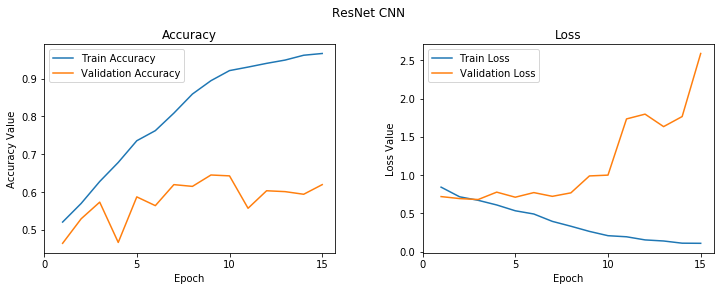

In [17]:
start = time()

in_model = resnet_model
model_name = 'ResNet'
epochs = 15
train_steps = 10
val_steps = 5
train_layers = ['conv5_block2_1_conv']
metrics=['accuracy']
validation_split = 0.2
train_batch_size = 30
val_batch_size = 20
loss='binary_crossentropy'
augment = False
model_path = '/Users/jacksimonson/Springboard_Work'
output = in_model.layers[-1].output
output = keras.layers.Flatten()(output)
_model = Model(in_model.input, output)
_model.trainable = True

set_trainable = False
for layer in _model.layers:
    if layer.name in train_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

input_shape = _model.output_shape[1]

model = Sequential()
model.add(_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

print(model.summary())
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_split = validation_split,
                    batch_size=train_batch_size,
                    epochs=epochs,
                    verbose=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
t = f.suptitle('{} CNN'.format(model_name), fontsize=12)

f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs + 1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
model.save(model_file_path)
    
transfer_results[model_name] = (model, history, model_file_path)
    
end = time()
elapsed = (end-start)/60

print(f'{model_name} train time is %f minutes.' % elapsed)

                                           Layer Type    Layer Name  \
0   <tensorflow.python.keras.engine.input_layer.In...      input_10   
1   <tensorflow.python.keras.layers.convolutional....  block1_conv1   
2   <tensorflow.python.keras.layers.convolutional....  block1_conv2   
3   <tensorflow.python.keras.layers.pooling.MaxPoo...   block1_pool   
4   <tensorflow.python.keras.layers.convolutional....  block2_conv1   
5   <tensorflow.python.keras.layers.convolutional....  block2_conv2   
6   <tensorflow.python.keras.layers.pooling.MaxPoo...   block2_pool   
7   <tensorflow.python.keras.layers.convolutional....  block3_conv1   
8   <tensorflow.python.keras.layers.convolutional....  block3_conv2   
9   <tensorflow.python.keras.layers.convolutional....  block3_conv3   
10  <tensorflow.python.keras.layers.convolutional....  block3_conv4   
11  <tensorflow.python.keras.layers.pooling.MaxPoo...   block3_pool   
12  <tensorflow.python.keras.layers.convolutional....  block4_conv1   
13  <t

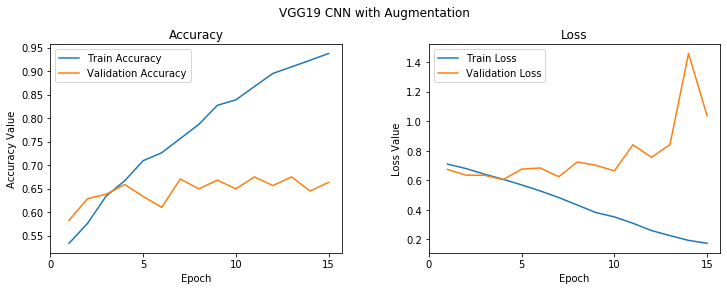

In [18]:
start = time()

in_model = vgg19_model
model_name = 'VGG19'
epochs = 15
train_steps = 10
val_steps = 5
train_layers = ['block5_conv1', 'block4_conv1']
metrics=['accuracy']
validation_split = 0.2
train_batch_size = 30
val_batch_size = 20
loss='binary_crossentropy'
augment = False
model_path = '/Users/jacksimonson/Springboard_Work'
output = in_model.layers[-1].output
output = keras.layers.Flatten()(output)
_model = Model(in_model.input, output)
_model.trainable = True

set_trainable = False
for layer in _model.layers:
    if layer.name in train_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

input_shape = _model.output_shape[1]

model = Sequential()
model.add(_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

print(model.summary())
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_split = validation_split,
                    batch_size=train_batch_size,
                    epochs=epochs,
                    verbose=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    

t = f.suptitle('{} CNN with Augmentation'.format(model_name), fontsize=12)

f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs + 1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
model.save(model_file_path)
    
    
transfer_results[model_name] = (model, history, model_file_path)

end = time()
elapsed = (end-start)/60

print(f'{model_name} train time is %f minutes.' % elapsed)

                                            Layer Type  \
0    <tensorflow.python.keras.engine.input_layer.In...   
1    <tensorflow.python.keras.layers.convolutional....   
2    <tensorflow.python.keras.layers.normalization_...   
3    <tensorflow.python.keras.layers.core.Activatio...   
4    <tensorflow.python.keras.layers.convolutional....   
..                                                 ...   
307  <tensorflow.python.keras.layers.merge.Concaten...   
308  <tensorflow.python.keras.layers.merge.Concaten...   
309  <tensorflow.python.keras.layers.core.Activatio...   
310  <tensorflow.python.keras.layers.merge.Concaten...   
311  <tensorflow.python.keras.layers.core.Flatten o...   

                  Layer Name  Layer Trainable  
0                   input_12            False  
1                 conv2d_196            False  
2    batch_normalization_188            False  
3             activation_188            False  
4                 conv2d_197            False  
..             

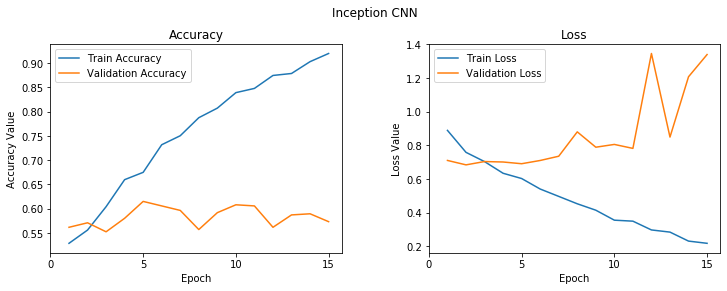

In [19]:
start = time()

in_model = inception_model
model_name = 'Inception'
epochs = 15
train_steps = 10
val_steps = 5
train_layers = ['conv2d_83']
metrics=['accuracy']
validation_split = 0.2
train_batch_size = 30
val_batch_size = 20
loss='binary_crossentropy'
augment = False
model_path = '/Users/jacksimonson/Springboard_Work'
output = in_model.layers[-1].output
output = keras.layers.Flatten()(output)
_model = Model(in_model.input, output)
_model.trainable = True


set_trainable = False
for layer in _model.layers:
    if layer.name in train_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

input_shape = _model.output_shape[1]

model = Sequential()
model.add(_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

print(model.summary())
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_split = validation_split,
                    batch_size=train_batch_size,
                    epochs=epochs,
                    verbose=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
t = f.suptitle('{} CNN'.format(model_name), fontsize=12)

f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs + 1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
model.save(model_file_path)
    
transfer_results[model_name] = (model, history, model_file_path)
    
end = time()
elapsed = (end-start)/60

print(f'{model_name} train time is %f minutes.' % elapsed)

### Test Models

In [30]:
def test_models(model_file_path = None, test_labels_enc = None, test_imgs = None):
    if model_file_path is None:
        raise Exception('Specify a model file path')
    
    print('loading model...')
    model = keras.models.load_model(model_file_path)
    print('loaded {}'.format(model_file_path.replace('.h5', '').split('/')[-1].replace('_', ' ').title()))
    
    y_pred = model.predict_classes(test_imgs, verbose=1)
    con_mat = tf.math.confusion_matrix(labels = test_labels_enc, predictions = y_pred).numpy()
    
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df_norm = pd.DataFrame(con_mat_norm,
                              index = ['Benign', 'Malignant'], 
                              columns = ['Benign', 'Malignant'])

    con_mat_df = pd.DataFrame(con_mat,
                              index = ['Benign', 'Malignant'], 
                              columns = ['Benign', 'Malignant'])

    tp = con_mat_df['Malignant'][1]
    tn = con_mat_df['Benign'][0]
    fp = con_mat_df['Benign'][1]
    fn = con_mat_df['Malignant'][0]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fn_rate = fn / (fn+tp)
    fp_rate = tn / (tn+fp)
    f1 = 2 * ((precision*recall) / (precision+recall))
    
    print('\nTrue Positive: {}'.format(tp))
    print('False Positive: {}'.format(fp))
    print('True Negative: {}'.format(tn))
    print('False Negative: {}\n'.format(fn))

    print('Accuracy: {:.3f}'.format((tp+tn)/len(y_pred)))
    print('Precision: {:.3f}'.format(precision))
    print('Recall: {:.3f}'.format(recall))
    print('F-score: {:.3f}'.format(f1))
    print('False Negative Rate: {:.3f}'.format(fn_rate))
    print('False Positive Rate: {:.3f}'.format(fp_rate))
    print('True Negative Rate: {:.3f}'.format(1-fp_rate))
    print('True Positive Rate: {:.3f}'.format(recall))

    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df_norm, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.title(model_file_path.replace('.h5', '').split('/')[-1].replace('_', ' ').title())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    from sklearn.metrics import auc
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds_keras = roc_curve(test_labels_enc, y_pred)
    auc = auc(fpr, tpr)

    return (fpr, tpr, auc)

loading model...
loaded Vanilla Cnn Model
18/18 [==============================] - 3s 188ms/step

True Positive: 139
False Positive: 125
True Negative: 187
False Negative: 120

Accuracy: 0.571
Precision: 0.527
Recall: 0.537
F-score: 0.532
False Negative Rate: 0.463
False Positive Rate: 0.599
True Negative Rate: 0.401
True Positive Rate: 0.537


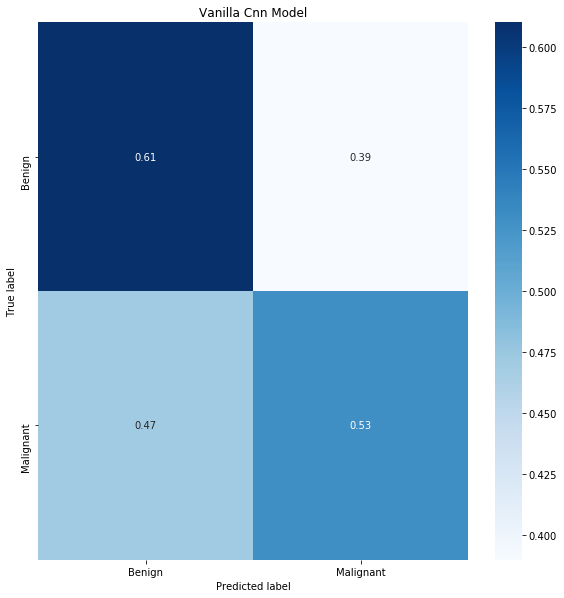

loading model...
loaded Vanilla Cnn Model With Augmentation
18/18 [==============================] - 3s 186ms/step

True Positive: 209
False Positive: 55
True Negative: 53
False Negative: 254

Accuracy: 0.459
Precision: 0.792
Recall: 0.451
F-score: 0.575
False Negative Rate: 0.549
False Positive Rate: 0.491
True Negative Rate: 0.509
True Positive Rate: 0.451


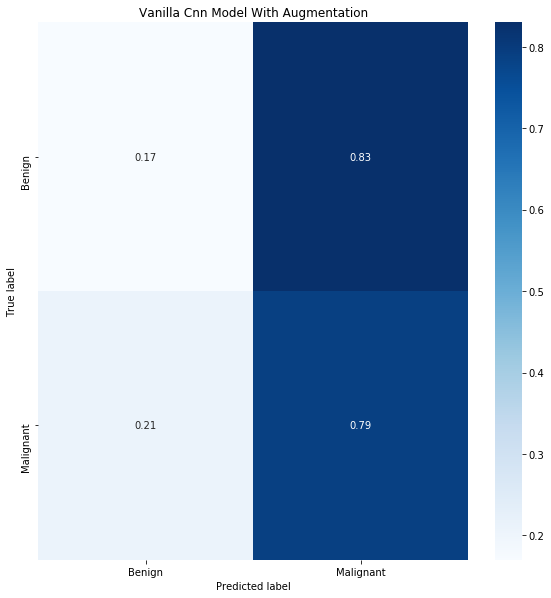

loading model...
loaded Resnet Transfer Model
18/18 [==============================] - 34s 2s/step

True Positive: 237
False Positive: 27
True Negative: 71
False Negative: 236

Accuracy: 0.539
Precision: 0.898
Recall: 0.501
F-score: 0.643
False Negative Rate: 0.499
False Positive Rate: 0.724
True Negative Rate: 0.276
True Positive Rate: 0.501


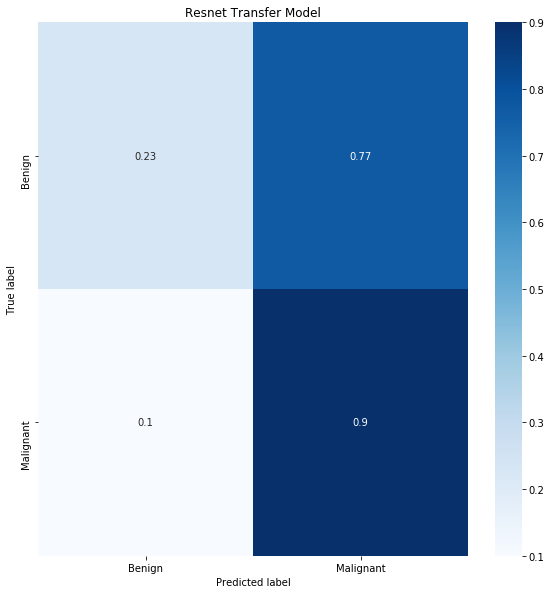

loading model...
loaded Vgg19 Transfer Model
18/18 [==============================] - 47s 3s/step

True Positive: 162
False Positive: 102
True Negative: 190
False Negative: 117

Accuracy: 0.616
Precision: 0.614
Recall: 0.581
F-score: 0.597
False Negative Rate: 0.419
False Positive Rate: 0.651
True Negative Rate: 0.349
True Positive Rate: 0.581


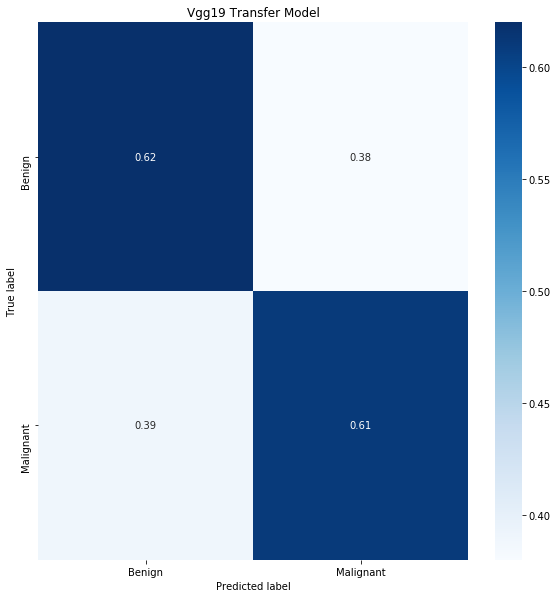

loading model...
loaded Inception Transfer Model
18/18 [==============================] - 9s 492ms/step

True Positive: 241
False Positive: 23
True Negative: 52
False Negative: 255

Accuracy: 0.513
Precision: 0.913
Recall: 0.486
F-score: 0.634
False Negative Rate: 0.514
False Positive Rate: 0.693
True Negative Rate: 0.307
True Positive Rate: 0.486


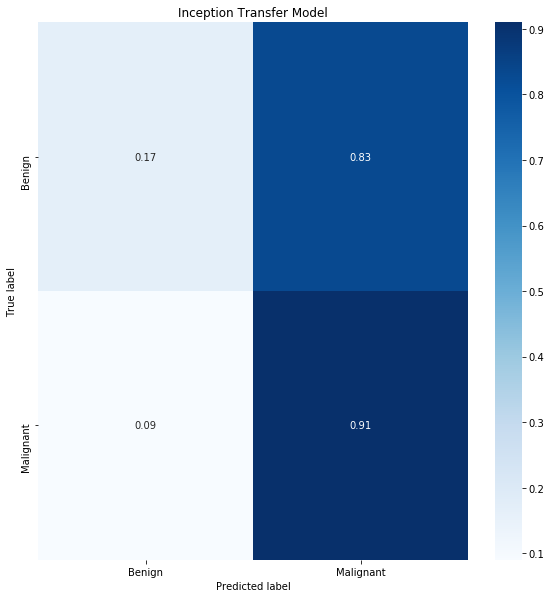

In [31]:
base_dir = '/Users/jacksimonson/Springboard_Work'

models = {'{}/vanilla_cnn_model.h5'.format(base_dir): test_imgs_scaled,
          '{}/vanilla_cnn_model_with_augmentation.h5'.format(base_dir): test_imgs_scaled,
          '{}/ResNet_transfer_model.h5'.format(base_dir): test_imgs_scaled,
          '{}/VGG19_transfer_model.h5'.format(base_dir): test_imgs_scaled,
          '{}/Inception_transfer_model.h5'.format(base_dir): test_imgs_scaled}

roc_auc_info = {}
for model_file_path, imgs in models.items():
    model_name = model_file_path.split('/')[-1].replace('.h5','').replace('_', ' ')
    roc_auc_info[model_name] = test_models(model_file_path = model_file_path, test_labels_enc = test_labels_enc, test_imgs = imgs)

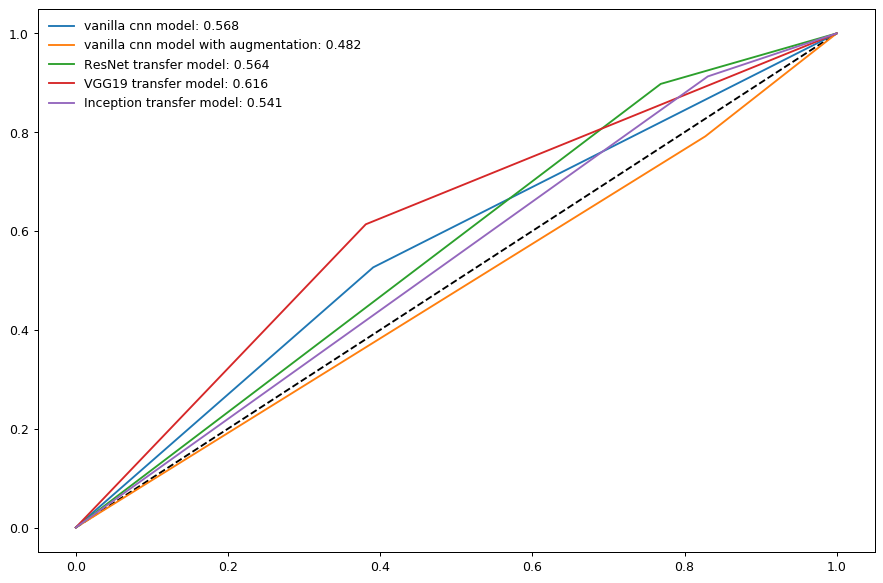

In [33]:
fig = plt.figure(figsize=(12,8), dpi = 90)
plt.plot([0, 1], [0, 1], 'k--')
for model_name, tup in roc_auc_info.items():
    fpr, tpr, auc = tup    
    plt.plot(fpr, tpr, label='{}: {:.3f}'.format(model_name, auc))
plt.legend(frameon=False)
plt.show()